# Forest Fire Spreading 


## Background

Wildfires are one of the most harmful phenomena in Chile burning thousands of forest hectares every year destroying significant flora and fauna, and affecting the air, water cycles, and the ecosystem. Wildfires start by varied reasons, ranging from reckless human behavior to extreme weather and environmental conditions

## Main Goal

Build a mathematical model based on PDE qualitatively realistic with the phenomenon behaviour. 

## Objectives
1. Start with an agent based model, working with the weather conditions and initial fires focus. 
2. Get a continuous model based on PDE from the ABM.
3. Assess wind relevance to the model.

In [1]:
import firemodels.cellularautomata as ca
import firemodels.cellularautomatalayers as cal
import firemodels.temperature as temp
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

## Cellular Automata

In [2]:
def fireFocus(M, N, i, j, size):
    focus = np.zeros((M, N))
    focus[i-size:i+size, j-size:j+size] = np.ones((2*size, 2*size)) 
    return focus

In [3]:
def plotStates(t=0):
    play = widgets.Play(
        value=0,
        min=0,
        max=len(states)-1,
        step=1,
        description="Press play",
        disabled=False
    )
    slider = widgets.IntSlider()
    widgets.jslink((play, 'value'), (slider, 'value'))
    widgets.HBox([play, slider])
    widgets.interact(automata.plotStates, t=play)

In [4]:
# Testing
M = 101
N = 101
initial = fireFocus(M, N, 50, 50, 2)
rule = .35
#neighborhood = 'vonneumann'
neighborhood = 'moore'
times = 100

In [5]:
automata = ca.new(M, N, initial, rule, neighborhood)
states = automata.propagate(times)

In [6]:
plotStates()

interactive(children=(Play(value=0, description='Press play', max=99), Output()), _dom_classes=('widget-intera…

# Cellular Automata with layers

In [7]:
temperature = np.load('data/temperature100x100.npy')
wind_speed = np.load('data/wind_speed100x100.npy')
humidity = np.load('data/humidity100x100.npy')
pressure = np.load('data/pressure100x100.npy')

In [8]:
temperature = temperature / np.max(temperature)
wind_speed = wind_speed / np.max(wind_speed)
humidity = humidity / np.max(humidity)
pressure = pressure / np.max(pressure)

In [9]:
# Testing
(M, N) = temperature.shape
wd = np.ones_like(temperature)*0
world = [temperature, wind_speed, wd, humidity, pressure]
initial = fireFocus(M, N, 50, 50, 2)
#neighborhood = 'vonneumann'
neighborhood = 'moore'
alpha = .5
beta = 1-alpha
times = 200
rule = .3

In [10]:
automata = cal.new(initial, world, neighborhood, rule, alpha, beta)
states = automata.propagate(times)

In [11]:
plotStates()

interactive(children=(Play(value=0, description='Press play', max=199), Output()), _dom_classes=('widget-inter…

* $BT$: Burning trees
* $T$: Temperature

# Discrete Model

## Temperature

### Discrete

\begin{equation}
    \begin{split}
        T_{i,j}^{k+1} & = T_{i,j}^k - \frac45 T_{i,j}^k 
            + \frac15\left(T_{i-1,j}^k+T_{i+1,j}^k+T_{i,j-1}^k+T_{i,j+1}^k\right) \\
            & = \frac15\left(T_{i-1,j}^k+T_{i+1,j}^k+T_{i,j}^k+T_{i,j-1}^k+T_{i,j+1}^k\right)
    \end{split}
\end{equation}

In [12]:
def temperatureFocus(M, N):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, M)
    X, Y = np.meshgrid(x, y)
    return 1e3*np.exp(-1000*((X-.5)**2 + (Y-.5)**2))

In [13]:
M, N = 100, 100
initial = temperatureFocus(M, N)
times = 100
c = 1/5

In [14]:
dte = temp.discrete(c, 0, times, initial)
dtemps = dte.propagate()

In [15]:
widgets.interact(dte.plotTemperatures, t=widgets.IntSlider(min=0, max=len(dtemps)-1, continuous_update=False),
                 temperatures=widgets.fixed(dtemps))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=99), Output()), _dom_cl…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### With Forest

In [16]:
def temperatureFocus(M, N):
    temperature = np.zeros((M,N))
    A = np.zeros((M,N))
    A[M//2, N//2] = 1
    A[M//2+1, N//2] = 1
    temperature = temperature + A * 600
    return temperature, A

In [17]:
def temperatureFocus2(M, N, radius=20, dom=1, shape=-1000):
    # Initial trees burning
    tree = np.zeros((M,N))
    tree[M//2, N//2] = 1
    tree[M//2+1, N//2] = 1
    # Initial temperature
    x = np.linspace(0, dom, N)
    y = np.linspace(0, dom, M)
    X, Y = np.meshgrid(x, y)
    temperature = 1e3*np.exp(shape*((X-dom/2)**2 + (Y-dom/2)**2))
    #temperature = np.zeros((M,N))
    #temperature = temperature + tree * 600
    fuel = np.zeros((M,N))
    cx, cy = M//2, N//2 # The center of circle
    y, x = np.ogrid[-radius: radius, -radius: radius]
    index = x**2 + y**2 <= radius**2
    fuel[cy-radius:cy+radius, cx-radius:cx+radius][index] = 1
    return temperature, tree, fuel

In [18]:
M, N = 100, 100
#initial, A = temperatureFocus(M, N)
T0, A0, Y0 = temperatureFocus2(M, N)
times = 300
c = 1/5
b = 8
maxTemp = 1000

In [19]:
dt2 = temp.discrete(c, 0, times, T0, A0, np.zeros_like(T0), None, b, maxTemp)

In [20]:
dt2a_temps, dt2a_As, dt2a_fuels = dt2.propagate()

In [21]:
widgets.interact(dt2.plotTemperatures, t=widgets.IntSlider(min=0, max=len(dt2a_temps)-1, 
    continuous_update=False), temperatures=widgets.fixed(dt2a_temps))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_c…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### Stochastic

\begin{equation}
    T_{i,j}^{k+1} = T_{i,j}^{k} - 4 \, c \, T_{i,j}^{k} + (c + \sigma_1 \Delta  \, Z^k_{i,j}) \left(T_{i+1,j}^{k} + T_{i-1,j}^{k} + T_{i,j+1}^{k} + T_{i,j-1}^{k}\right) + \sigma_2 \Delta W^k_{i,j}
\end{equation}

#### Approach 1 $\sigma_1=0$

In [22]:
dt2b_temps, dt2b_A, _ = dt2.propagate(None, 5)

In [23]:
widgets.interact(dt2.plotTemperatures, t=widgets.IntSlider(min=0, max=len(dt2b_temps)-1, 
    continuous_update=False), temperatures=widgets.fixed(dt2b_temps))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_c…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### Approach 2 $\sigma_1, \sigma_2 \neq 0$

In [24]:
dt2c_temps, dt2c_A, _ = dt2.propagate(1/6, 1)

In [25]:
widgets.interact(dt2.plotTemperatures, t=widgets.IntSlider(min=0, max=len(dt2c_temps)-1, 
    continuous_update=False), temperatures=widgets.fixed(dt2c_temps))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_c…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### Fuel added

\begin{equation}
    \begin{split}
        T_{i,j}^{k+1} & = T_{i,j}^{k} - 4 \, c \, T_{i,j}^{k} + (c + \sigma_1 \Delta  \, Z^k_{i,j}) \left(T_{i+1,j}^{k} + T_{i-1,j}^{k} + T_{i,j+1}^{k} + T_{i,j-1}^{k}\right) + \sigma_2 \Delta W^k_{i,j} + H\, A^k_{i,j}\,Y_{i,j}^k \, Z  \exp(E/T^k_{i,j}) \\
        Y^{k+1}_{i,j} & = Y^k_{i,j} - \,Y_{i,j}^k \, Z  \exp(E/T^k_{i,j})
    \end{split}
\end{equation}

#### With Forest and Fuel $\sigma_1=\sigma_2=0$

In [26]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
times = 300
c = 1/5
Ea = 1
Z = .1
H = 5500
b = 8
maxTemp = 1000
dt3 = temp.discrete(c, 0, times, T0, A0, Y0, None, b, maxTemp, Ea, Z, H)
dt3a_temps, dt3a_As, dt3a_fuel = dt3.propagate()#4/30, 20)

In [27]:
widgets.interact(dt3.plotSimulation, t=widgets.IntSlider(min=0, max=len(dt3a_temps)-1, continuous_update=False), 
                 temperatures=widgets.fixed(dt3a_temps), fuels=widgets.fixed(dt3a_fuel), trees=widgets.fixed(dt3a_As))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_c…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### With Forest and Fuel Stochastic  $\sigma_1, \sigma_2 \neq 0$

In [28]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
times = 300
c = 1/5
Ea = 1e-5
Z = .1
H = 5500
b = 8
maxTemp = 1000
dt3_2 = temp.discrete(c, 0, times, T0, A0, Y0, None, b, maxTemp, Ea, Z, H)#temp.discrete(c, initial, times, A, b, maxTemp, Ea*1e-5, Z, H)
dt3b_temps, dt3b_As, dt3b_fuel = dt3_2.propagate(1/10, 20)

In [29]:
widgets.interact(dt3.plotSimulation, t=widgets.IntSlider(min=0, max=len(dt3b_temps)-1, 
    continuous_update=False), temperatures=widgets.fixed(dt3b_temps), fuels=widgets.fixed(dt3b_fuel), trees=widgets.fixed(dt3b_As))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_c…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### With wind

\begin{equation}
    \begin{split}
        T_{i,j}^{k+1} & = T_{i,j}^{k} - 4 \, c \, T_{i,j}^{k} + (c + \sigma_1 \Delta  \, Z^k_{i,j}) 
            \left(T_{i+1,j}^{k} + T_{i-1,j}^{k} + T_{i,j+1}^{k} + T_{i,j-1}^{k}\right) 
            + \gamma(V_x+V_y)+ \sigma_2 \Delta W^k_{i,j} + H\, A^k_{i,j} \,Y_{i,j}^k \, Z  \exp(-E/T^k_{i,j}) \\
        Y^{k+1}_{i,j} & = Y^k_{i,j} - \,Y_{i,j}^k \, Z  \exp(-E/T^k_{i,j})
    \end{split}
\end{equation}

Where:

$$V_x=\begin{cases}-v_x(T_{i,j}^k - T_{i-1,j}^k) & \textrm{if } v_x \geq 0 \\-v_x(T_{i+1,j}^k - T_{i,j}^k) & \textrm{otherwise}\end{cases}$$

$$V_y=\begin{cases}-v_y(T_{i,j}^k - T_{i,j-1}^k) & \textrm{if } v_y \geq 0 \\-v_y(T_{i,j+1}^k - T_{i,j}^k) & \textrm{otherwise}\end{cases}$$

In [30]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
times = 300
c = 1/5
Ea = 1e-3
Z = .1
H = 5500
b = 8
maxTemp = 1000
gamma = 1
V = [(-.1, -.1)]
dtempv = temp.discrete(c, gamma, times, T0, A0, Y0, V, b, maxTemp, Ea, Z, H) 
dtempvs, Asv, fuelsv = dtempv.propagate()#1/13, 15)

In [31]:
widgets.interact(dtempv.plotSimulation, t=widgets.IntSlider(min=0, max=len(dtempvs)-1, 
    continuous_update=False), temperatures=widgets.fixed(dtempvs), fuels=widgets.fixed(fuelsv), trees=widgets.fixed(Asv))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_c…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### Newton's law of cooling

\begin{equation}
    \begin{split}
        T_{i,j}^{k+1} & = T_{i,j}^{k} - 4 \, c \, T_{i,j}^{k} + (c + \sigma_1 \Delta  \, Z^k_{i,j}) 
            \left(T_{i+1,j}^{k} + T_{i-1,j}^{k} + T_{i,j+1}^{k} + T_{i,j-1}^{k}\right)
            + \gamma(V_x+V_y) + H\, A^k_{i,j} \,Y_{i,j}^k \, Z  \exp(-E/T^k_{i,j}) 
            \, - h(T_{i,j}^k - T_{env}) + \sigma_2 \Delta W^k_{i,j} \\
        Y^{k+1}_{i,j} & = Y^k_{i,j} - \,Y_{i,j}^k \, Z  \exp(-E/T^k_{i,j})
    \end{split}
\end{equation}

Where:

$$V_x=\begin{cases}-v_x(T_{i,j}^k - T_{i-1,j}^k) & \textrm{if } v_x \geq 0 \\-v_x(T_{i+1,j}^k - T_{i,j}^k) & \textrm{otherwise}\end{cases}$$

$$V_y=\begin{cases}-v_y(T_{i,j}^k - T_{i,j-1}^k) & \textrm{if } v_y \geq 0 \\-v_y(T_{i,j+1}^k - T_{i,j}^k) & \textrm{otherwise}\end{cases}$$

In [32]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.ones_like(T0)
Y0 = np.ones_like(T0)
times = 300
c = 1/5
Z = .1
H = 5500
b = 8
maxTemp = 1000
Ea = 1
h = 1e-2
T_ref = 30
dtenv = temp.discrete(c, gamma, times, T0, A0, Y0, V, b, maxTemp, Ea, Z, H, h, T_ref) 
dtsenv, Asenv, fsenv = dtenv.propagate()

In [33]:
widgets.interact(dtempv.plotSimulation, t=widgets.IntSlider(min=0, max=len(dtsenv)-1, 
    continuous_update=False), temperatures=widgets.fixed(dtsenv), fuels=widgets.fixed(fsenv), trees=widgets.fixed(Asenv))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=299), Output()), _dom_c…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [34]:
np.max(dtsenv[0])

950.26422400190597

## Coefficients scale experiments

To build the continous model, we have to check the relationship between coefficients and space/time discretization.

### Diffusion scale

#### Time discretization 

Testing $c=c'\, \Delta t$

In [35]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
c = 1/5

In [36]:
dt = 1
c1 = c*dt
ct1 = temp.discrete(c1, 0, 100, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tct1, Act1, Fct1 = ct1.propagate()
print(np.max(Tct1[-1]))

109.181009436


In [37]:
dt = 1/2
c2 = c*dt
ct2 = temp.discrete(c2, 0, 200, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tct2, Act2, Fct2 = ct2.propagate()
print(np.max(Tct2[-1]))

109.12772966


In [38]:
dt = 1/3
c3 = c*dt
ct3 = temp.discrete(c3, 0, 300, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tct3, Act3, Fct3 = ct3.propagate()
print(np.max(Tct3[-1]))

109.109897324


##### Final temperature plot

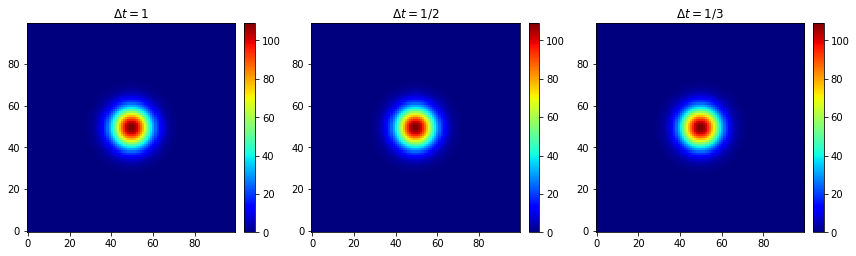

In [39]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tct1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tct2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1/2$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(Tct3[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1/3$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

##### Error plot

Error:  0.0388158325655
Error:  0.155403437495


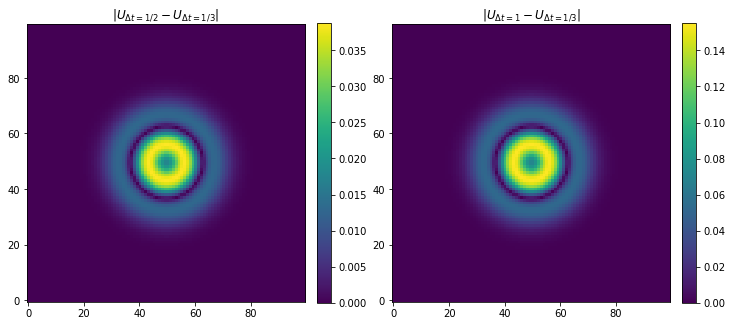

In [40]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(Tct2[-1] - Tct3[-1]), origin="lower")
plt.title(r"$|U_{\Delta t = 1/2}-U_{\Delta t = 1/3}|$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 2, 2)
plt.imshow(np.abs(Tct1[-1] - Tct3[-1]), origin="lower")
plt.title(r"$|U_{\Delta t = 1}-U_{\Delta t = 1/3}|$")
plt.colorbar(fraction=0.046, pad=0.04)
print("Error: ", np.linalg.norm(Tct2[-1].flatten() - Tct3[-1].flatten(), np.inf))
print("Error: ", np.linalg.norm(Tct1[-1].flatten() - Tct3[-1].flatten(), np.inf))

#### Space discretization

Testing $c=\frac{c'}{m^2}$, for $\Delta x = \Delta y = m$.

In [41]:
times = 75

In [42]:
M, N = 128, 128
T0, A0, Y0 = temperatureFocus2(M, N, 10)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
m = 100/M
c1 = 1/5*m**-2
cs1 = temp.discrete(c1, 0, times, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tcs1, Acs1, Fcs1 = cs1.propagate()
print(np.max(Tcs1[-1]))

141.60056943


In [43]:
M, N = 64, 64
T0, A0, Y0 = temperatureFocus2(M, N, 10)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
m = 100/M
c2 = 1/5*m**-2
cs2 = temp.discrete(c2, 0, times, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tcs2, Acs2, Fcs2 = cs2.propagate()
print(np.max(Tcs2[-1]))

138.920235499


In [44]:
M, N = 32, 32
T0, A0, Y0 = temperatureFocus2(M, N, 10)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 75
m = 100/M
c3 = 1/5*m**-2
cs3 = temp.discrete(c3, 0, times, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tcs3, Acs3, Fcs3 = cs3.propagate()
print(np.max(Tcs3[-1]))

133.752836713


##### Final temperature plot

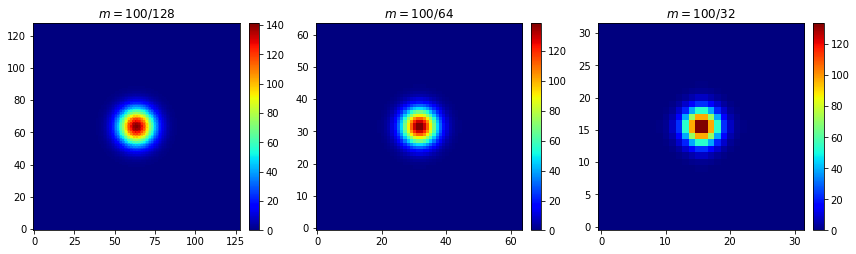

In [45]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tcs1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$m = 100 / 128$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tcs2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$m = 100 / 64$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(Tcs3[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$m = 100 / 32$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

##### Error plot

Error m=100/64, m=100/32:  19.4846581899
Error m=100/128, m=100/32:  27.4216147243


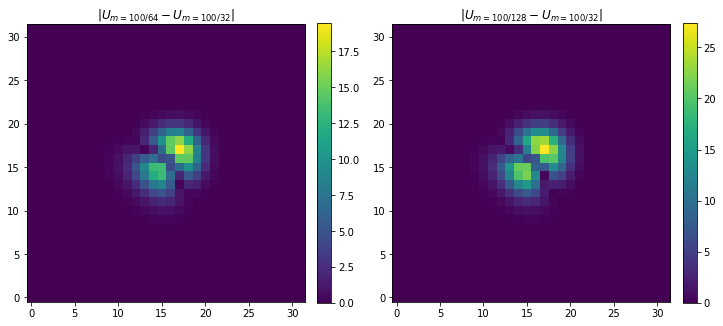

In [46]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(Tcs2[-1][::2,::2] - Tcs3[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$|U_{m = 100/64}-U_{m = 100/32}|$")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(Tcs1[-1][::4,::4] - Tcs3[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$|U_{m = 100/128}-U_{m = 100/32}|$")
print("Error m=100/64, m=100/32: ", np.linalg.norm(Tcs2[-1][::2,::2].flatten() - Tcs3[-1].flatten(), np.inf))
print("Error m=100/128, m=100/32: ", np.linalg.norm(Tcs1[-1][::4,::4].flatten() - Tcs3[-1].flatten(), np.inf))

### Gamma scale

Testing $\gamma=\frac{\gamma'}{m}$

In [47]:
times = 100
gamma = 1/8

In [48]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
m = 100/M
g1 = gamma / m
gs1 = temp.discrete(0, g1, times, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tgs1, Ags1, Fgs1 = gs1.propagate()
i,j = np.unravel_index(Tgs1[-1].argmax(), Tgs1[-1].shape)
print(i, j, Tgs1[-1][i, j])

44 44 450.484505416


In [49]:
M, N = 200, 200
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
times = 100
m = 100/M
g2 = gamma / m
gs2 = temp.discrete(0, g2, times, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tgs2, Ags2, Fgs2 = gs2.propagate()
i,j = np.unravel_index(Tgs2[-1].argmax(), Tgs2[-1].shape)
print(i, j, Tgs2[-1][i, j])

87 87 646.25683504


##### Error plot

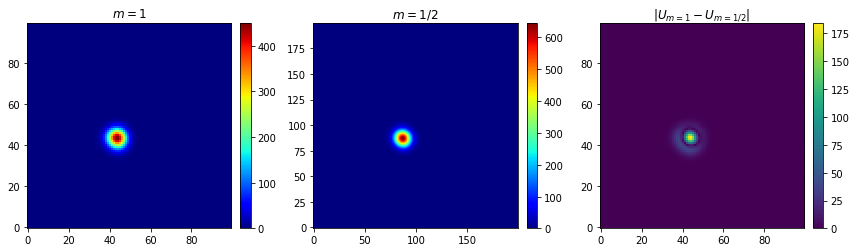

Error: 184.198783022


In [50]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tgs1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$m = 1$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tgs2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$m = 1 / 2$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(Tgs2[-1][::2,::2] - Tgs1[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$|U_{m = 1}-U_{m = 1/2}|$")
plt.tight_layout()
plt.show()
print("Error:", np.linalg.norm(Tgs2[-1][::2,::2].flatten() - Tgs1[-1].flatten(), np.inf))

Testing $\gamma=\gamma'\Delta t$

In [51]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
gamma = 1 / 8

In [52]:
dt = 1
g1 = gamma * dt
gt1 = temp.discrete(0, g1, 100, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tgt1, Agt1, Fgt1 = gt1.propagate()
i,j = np.unravel_index(Tgt1[-1].argmax(), Tgt1[-1].shape)
print(i, j, Tgt1[-1, i, j])

44 44 450.484505416


In [53]:
dt = 1/2
g2 = gamma * dt
gt2 = temp.discrete(0, g2, 200, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tgt2, Agt2, Fgt2 = gt2.propagate()
i,j = np.unravel_index(Tgt2[-1].argmax(), Tgt2[-1].shape)
print(i, j, Tgt2[-1, i, j])

44 44 442.120562446


In [54]:
dt = 1/3
g3 = gamma * dt
gt3 = temp.discrete(0, g3, 300, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, 0, 0) 
Tgt3, Agt3, Fgt3 = gt3.propagate()
i,j = np.unravel_index(Tgt3[-1].argmax(), Tgt3[-1].shape)
print(i, j, Tgt3[-1, i, j])

44 44 439.437957444


##### Final temperature plot

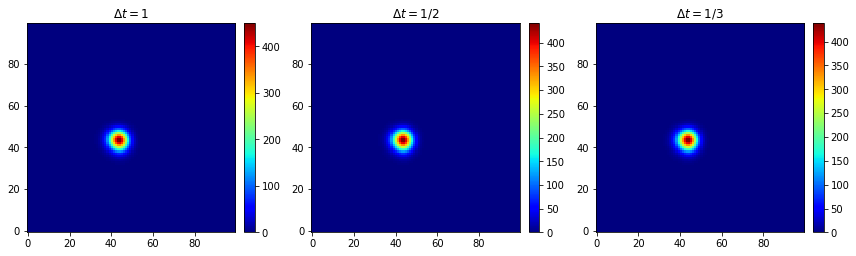

In [55]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tgt1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tgt2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1/2$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(Tgt3[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1/3$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

##### Error plot

Error dt=1/2, dt=1:  8.57859270265
Error dt=1/3, dt=1:  11.3339954208


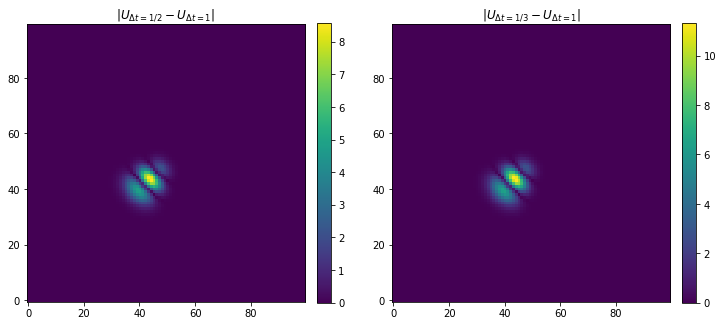

In [56]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(Tgt2[-1] - Tgt1[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$|U_{\Delta t = 1/2}-U_{\Delta t = 1}|$")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(Tgt3[-1] - Tgt1[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$|U_{\Delta t = 1/3}-U_{\Delta t = 1}|$")
print("Error dt=1/2, dt=1: ", np.linalg.norm(Tgt2[-1].flatten() - Tgt1[-1].flatten(), np.inf))
print("Error dt=1/3, dt=1: ", np.linalg.norm(Tgt3[-1].flatten() - Tgt1[-1].flatten(), np.inf))

### Z Scale

Testing that $Z$ doesn't depend on $\Delta x$. 

In [57]:
H = 5500
T_ref = 1
times = 10

In [58]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
Z1 = 0.1
zs1 = temp.discrete(0, 0, times, T0, A0, Y1, [(0,0)], 8, maxTemp, 1, Z1, H, 0, T_ref) 
Tzs1, Azs1, Fzs1 = zs1.propagate()
print(np.max(Tzs1[-1]))

4081.68446228


In [59]:
M, N = 300, 300
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
Z2 = 0.1
zs2 = temp.discrete(0, 0, times, T0, A0, Y1, [(0,0)], 8, maxTemp, 1, Z2, H, 0, T_ref) 
Tzs2, Azs2, Fzs2 = zs2.propagate()
print(np.max(Tzs2[-1]))

4125.86939905


##### Final temperature plot

Error:  3233.1964368


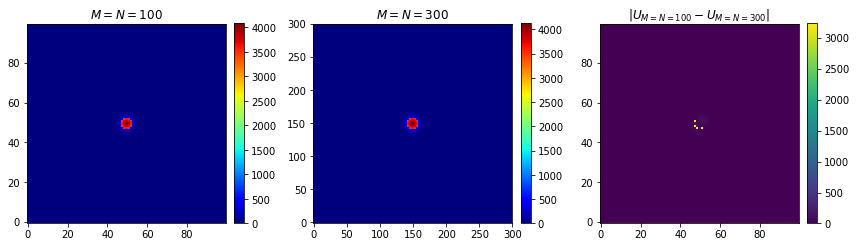

In [60]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tzs1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$M = N = 100$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tzs2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$M=N = 300$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(Tzs2[-1][::3,::3] - Tzs1[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$|U_{M=N=100}-U_{M=N=300}|$")
print("Error: ", np.linalg.norm(Tzs2[-1][::3,::3].flatten() - Tzs1[-1].flatten(), np.inf))
plt.tight_layout()
plt.show()

Testing $Z=Z'\, \Delta t$

In [61]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)

In [62]:
dt = 1
Zt1 = 0.1*dt
zt1 = temp.discrete(0, 0, 100, T0, A0, Y1, [(0,0)], 8, maxTemp, 1, Zt1, H, 0, T_ref) 
Tzt1, Azt1, Fzt1 = zt1.propagate()
print(np.max(Tzt1[-1]))

6396.86662239


In [63]:
dt = 1/2
Zt2 = 0.1*dt
zt2 = temp.discrete(0, 0, 200, T0, A0, Y1, [(0,0)], 8, maxTemp, 1, Zt2, H, 0, T_ref) 
Tzt2, Azt2, Fzt2 = zt2.propagate()
print(np.max(Tzt2[-1]))

6395.8203976


##### Final temperature plot

Error dt=1/2, dt=1:  1.04622478108


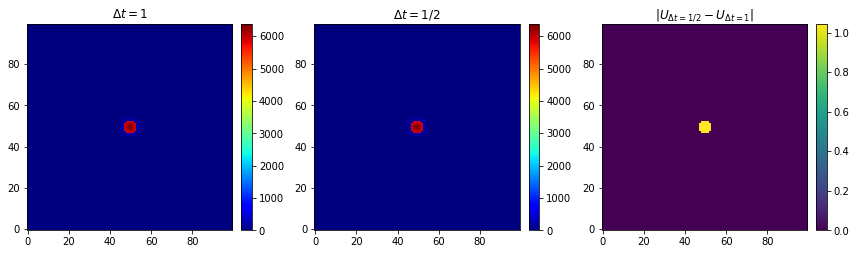

In [64]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tzt1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tzt2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1/2$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(Tzt2[-1] - Tzt1[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$|U_{\Delta t = 1/2}-U_{\Delta t = 1}|$")
print("Error dt=1/2, dt=1: ", np.linalg.norm(Tzt2[-1].flatten() - Tzt1[-1].flatten(), np.inf))
plt.tight_layout()
plt.show()

### Cooling Factor

Testing $h_{cool}$ doesn't depend on $h=\Delta x=\Delta y$.

In [65]:
times = 20
T_ref = 1

In [66]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
h1 = 0.1
hs1 = temp.discrete(0, 0, times, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, h1, T_ref) 
Ths1, Ahs1, Fhs1 = hs1.propagate()
print(np.max(Ths1[-1]))

129.231520752


In [67]:
M, N = 200, 200
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
h2 = 0.1
hs2 = temp.discrete(0, 0, times, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, h2, T_ref) 
Ths2, Ahs2, Fhs2 = hs2.propagate()
print(np.max(Ths2[-1]))

134.255230902


##### Final temperature plot

Error M=N=200, M=N=100:  13.1690346451


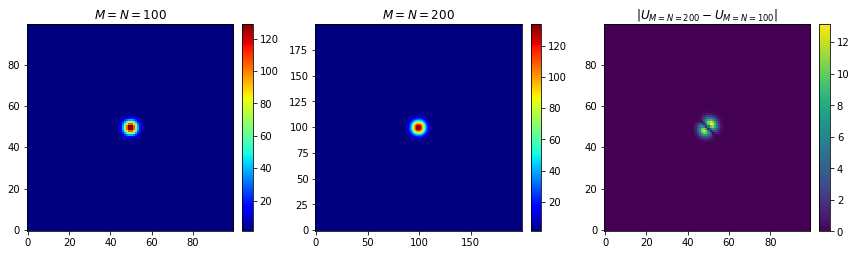

In [68]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Ths1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$M=N=100$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Ths2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$M=N=200$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(Ths2[-1][::2,::2] - Ths1[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$|U_{M=N=200}-U_{M=N=100}|$")
print("Error M=N=200, M=N=100: ", np.linalg.norm(Ths2[-1][::2,::2].flatten() - Ths1[-1].flatten(), np.inf))
plt.tight_layout()
plt.show()

Testing $h=h'\Delta t$

In [69]:
M, N = 100, 100
T0, A0, Y0 = temperatureFocus2(M, N)
A0 = np.zeros_like(A0)
Y1 = np.ones_like(Y0)
h = 0.1

In [70]:
dt = 1
h1 = h*dt
ht1= temp.discrete(0, 0, 100, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, h1, T_ref) 
Tht1, Aht, Fht = ht1.propagate()
print(np.max(Tht1[-1]))

1.02801531745


In [71]:
dt = 1/2
h2 = h*dt
ht2 = temp.discrete(0, 0, 200, T0, A0, Y1, [(-0.5,-0.5)], 0, 0, 0, 0, 0, h2, T_ref) 
Tht2, Aht2, Fht2 = ht2.propagate()
print(np.max(Tht2[-1]))

1.03502551792


##### Final temperature plot

Error Delta t = 1, Delta t = 1/2:  0.00701020047374


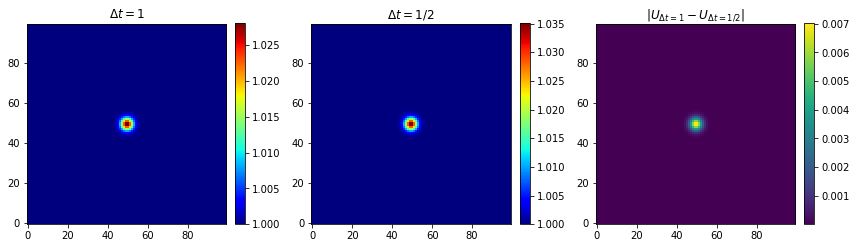

In [72]:
plt.figure(figsize=(12, 14))
plt.subplot(1, 3, 1)
plt.imshow(Tht1[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 2)
plt.imshow(Tht2[-1], origin="lower", cmap=plt.cm.jet)
plt.title(r"$\Delta t = 1/2$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(Tht2[-1] - Tht1[-1]), origin="lower")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$|U_{\Delta t = 1}-U_{\Delta t = 1/2}|$")
print("Error Delta t = 1, Delta t = 1/2: ", np.linalg.norm(Tht2[-1].flatten() - Tht1[-1].flatten(), np.inf))
plt.tight_layout()
plt.show()

Modelo discreto

In [73]:
M, N = 100, 100
K = 100
T = 1
dom = 10
T0, A0, Y0 = temperatureFocus2(M, N, dom=dom, shape=-1)
A0 = np.zeros_like(T0)
Y0 = np.ones_like(T0)
m = dom / M
dt = T / K
times = K
c = 1/5 * dt / (m**2)
gamma = 10 * dt / m
Z = .1 * dt
H = 2e4#5500
b = 8
maxTemp = 1000
Ea = 1
h = 1e-2 * dt
T_ref = 30

# Anillo
h = 1e1 * dt
gamma = 0
Z = 1 * dt

last = temp.discrete(c, gamma, times, T0, A0, Y0, [(-.1, -.1)], b, maxTemp, Ea, Z, H, h, T_ref) 
Tlast, Alast, Flast = last.propagate()

In [74]:
widgets.interact(last.plotSimulation, t=widgets.IntSlider(min=0, max=len(Tlast)-1, 
    continuous_update=False), temperatures=widgets.fixed(Tlast), fuels=widgets.fixed(Flast), trees=widgets.fixed(Alast))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=99), Output()), _dom_cl…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

# Continuous Model

\begin{align}\label{Tfinal}
    \frac{\partial T(x,y,t)}{\partial t} &=   d'\, \Delta T(x,y,t) 
    -  h' (T(x,y,t) - T_{\infty}) +  \gamma' \, (V_x + V_y) + \\ \nonumber
    & + A(x,y,t)\, \, H \, Y(x,y,t) \,  Z'  \exp\left(\displaystyle\frac{-T_a}{T(x,y,t)}\right) \\
\label{Yfinal}
       \frac{\partial Y(x,y,t)}{\partial t}&= - Y(x,y,t) \,Z'  \exp\left({\displaystyle\frac{-T_a}{T(x,y,t)}}\right) \\
\label{Vxfinal}V_x &= -v_x\,\frac{\partial T(x,y,t)}{\partial x}  \\
\label{Vyfinal}V_y &= -v_y\,\frac{\partial T(x,y,t)}{\partial y} \\
\label{Afinal}
    A(x,y,t) &= \begin{cases} 1, & \textrm{if}\,\, T(x,y,t) \geq T_{a} \\ 
    0, & \text{otherwise} \end{cases}
\end{align}

In [75]:
# Initial condition
u = lambda x, y: 1e3*np.exp(-1*((x-5)**2 + (y-5)**2))

# Domain
M, N = 100, 100
K = 100
T = 1
x = np.linspace(0, 10, N)
y = np.linspace(0, 10, M)
t = np.linspace(0, 1, K)
X, Y = np.meshgrid(x, y)

# Parameters
u0 = u(X, Y)
mu = 1/5 
gamma = 10 
T_ref = 30
V = (-.1, -.1)
A = np.zeros_like(u0)
y0 = np.ones_like(u0)
Z = .1 
h = 1e-2
Ea = 1
H = 2e4#5500

h = 1e1
gamma = 0
Z = 1

ct = temp.continuous(x, y, t, u0, y0, V, mu, gamma, A, Z, H, Ea, h, T_ref)

Tc, Ac, Yc = ct.solvePDE()

In [76]:
widgets.interact(ct.plotSimulation, t=widgets.IntSlider(min=0, max=len(Tc)-1, 
    continuous_update=False), temperatures=widgets.fixed(Tc), fuels=widgets.fixed(Yc), trees=widgets.fixed(Ac))

interactive(children=(IntSlider(value=0, continuous_update=False, description='t'), Output()), _dom_classes=('…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

# Data assimilation

## Topography

In [77]:
import csv

In [78]:
def CSVElevation(path):
    x, y, z = [], [], []
    with open(path, newline='') as csvfile:
        data = csv.reader(csvfile, delimiter='\t', quotechar='|')
        next(data, None)
        for row in data:
            y.append(float(row[1]))
            x.append(float(row[2]))
            z.append(float(row[3]))
        
    return np.array(x), np.array(y), np.array(z)

In [79]:
M, N = 100, 100

start_lat, start_lng = -33.088309, -71.655849
end_lat, end_lng = -33.141629, -71.594160

In [80]:
x, y, z = CSVElevation("data/valpo_elevation.csv")

In [81]:
X = x.reshape(M, N)
Y = y.reshape(M, N)
Z = z.reshape(M, N)

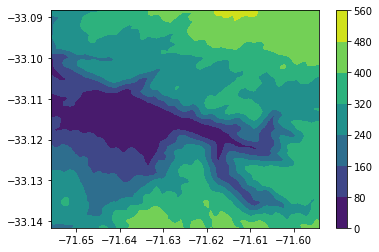

In [82]:
plt.contourf(X, Y, Z)
plt.colorbar()
plt.show()

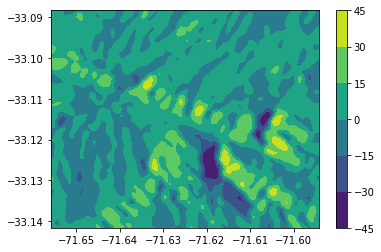

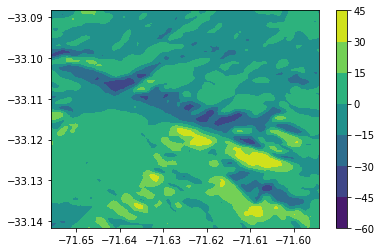

In [83]:
# Compute gradient
dx = 1.#X[0, 1] - X[0, 0]
dy = 1.#Y[0, 1] - Y[0, 0]
#Z_x = np.gradient(Z, dx, axis=1)
#Z_y = np.gradient(Z, dy, axis=0)
Z_x = np.gradient(Z, axis=1)
Z_y = np.gradient(Z, axis=0)
plt.contourf(X, Y, Z_x)
plt.colorbar()
plt.show()
plt.contourf(X, Y, Z_y)
plt.colorbar()
plt.show()

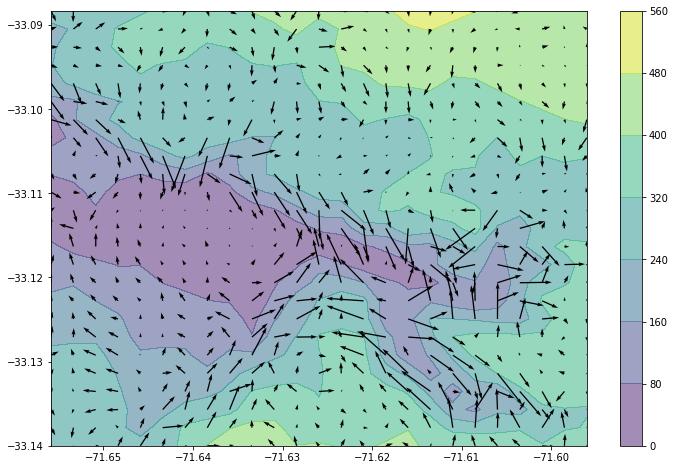

In [84]:
p = 4

nZ_x = np.zeros((M//p, N//p))
nZ_y = np.zeros((M//p, N//p))

for i in range(M//p):
    for j in range(N//p):
        nZ_x[i, j] = np.sum(Z_x[p*i:p*(i+1), p*j:p*(j+1)]) / (p**2)
        nZ_y[i, j] = np.sum(Z_y[p*i:p*(i+1), p*j:p*(j+1)]) / (p**2)
    
#elev = plt.contourf(X[::s,::s], Y[::s,::s], Z[::s,::s], alpha=.5)
plt.figure(figsize=(12, 8))
elv = plt.contourf(X[::p,::p], Y[::p,::p], Z[::p,::p], alpha=.5)
plt.quiver(X[::p,::p], Y[::p,::p], nZ_x, nZ_y)
plt.colorbar(elv)
plt.show()

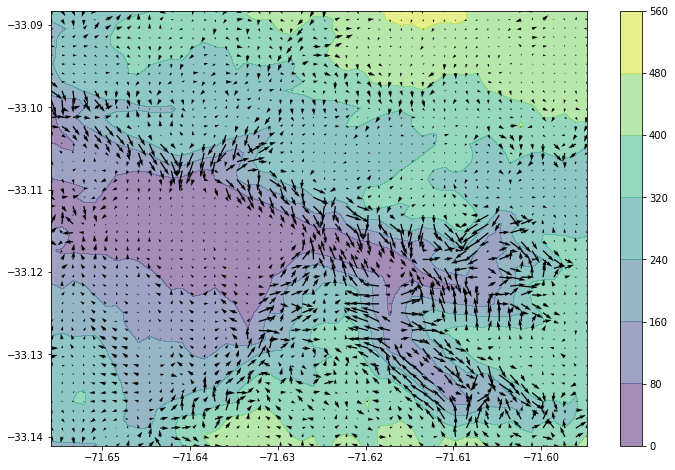

In [85]:
s = 2
plt.figure(figsize=(12, 8))
elev = plt.contourf(X[::s,::s], Y[::s,::s], Z[::s,::s], alpha=.5)
plt.quiver(X[::s,::s], Y[::s,::s], Z_x[::s,::s], Z_y[::s,::s])
plt.colorbar(elev)
plt.show()

## Wind

In [86]:
from scipy import interpolate

In [87]:
v_spe = np.load('data/speed.npy')
v_dir = np.load('data/direction.npy')

In [88]:
T = 50
speed = v_spe[-T:]#v_spe[:T]
direction = np.radians(v_dir[-T:])
t = np.linspace(0, 10*T, T)
#plt.plot(t, speed)
#plt.plot(t, direction)
#plt.show()

fs = interpolate.interp1d(t, speed, kind='cubic')
fd = interpolate.interp1d(t, direction, kind='cubic')
fine_t = np.linspace(0, 10*T, 10*T)
int_speed = fs(fine_t)
int_direction = fd(fine_t)
#plt.plot(fine_t, int_speed)
#plt.plot(fine_t, int_direction)
#plt.show()

xv = int_speed * np.cos(int_direction)
yv = int_speed * np.sin(int_direction)
#plt.plot(xv)
#plt.plot(yv)
#plt.show()

In [89]:
ONES = np.ones((10, 10))

In [90]:
def plotWind(i, u, v):
    plt.quiver(u[i]*ONES, v[i]*ONES)
    plt.show()

In [91]:
widgets.interact(plotWind, i=widgets.IntSlider(min=0, max=len(xv)-1), u=widgets.fixed(xv), v=widgets.fixed(yv))

interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact'…

<function __main__.plotWind(i, u, v)>

In [92]:
winds = list()
for i in range(len(xv)):
    winds.append((1e-2*xv[i], 1e-2*yv[i]))